# Two Armed Bandit

<img src="images/2armed.png"/>

## Background

Some people refer to slot machines as "One-armed Bandits" due to the older style 
of machine requiring the player to pull a mechanical handle to play. Statisticians 
and mathematicians often develop theories / models based on games of chance which 
turn out to be more generally useful. One general class of probability / optimization 
problems is known as the multi-armed bandit problem which is based on the following 
analogy: A player walks into a casino and sees a wall of slot machines. All of the 
machines pay out at different rates - some pay out more often than others, some 
pay out less often. Since the player does not know which machines are "good" and 
which are "bad", how should he / she play so as to make as much money (or at least 
lose as little) as possible?

### Load Libraries

In [1]:
#install.packages("package")
library(tidyverse)
library(statsr)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Simulated Slots

Today we will examine a simplified case where there are only two machines (one "Good" 
and one "Bad"). We will also assume that we know the probability of winning on 
the "Good" machine and the probability of winning on the "Bad" machine - what we 
don't know is which machine is which. 

The Shiny App below will let you simulate playing slot machines when the 
probability of winning on the "good" machine is 1/2 and the probability of 
winning on the "bad" machine is 1/3. Each time you play, the App will "flip a 
coin" and randomly select either Machine 1 or Machine 2 to be the "good" machine, 
and the other to be the "bad" machine.

In [2]:
#bandit_sim()

Use the Shiny App above to play the slot machines a total of *10* times. You can 
divide your plays up however you like between the two machines. Once you have 
played 10 times, use the results of your plays to decide which machine you think 
has the better payout (i.e. the good machine) - click the button on the right 
that corresponds to your guess, the App will tell you if you are right. If you 
were right or wrong, press the reset button and play again and guess which 
machine you think is the good machine. As you are playing, think about what it 
is about your results that enabled you make the correct guess.

Press the Reset button again, now play *30* times and use those results to guess 
which machine is the good one. Do you think it was easier or harder to make a 
decision with the additional plays? Why do you think that is?

    Answer: Whith more times, we have more chance to guess what is the correct machine. 

Hopefully what you have observed is that as you played the slot machine, initially 
it was difficult to determine which machine was which. But as you played more, it 
became more and more clear. In particular, each time you played you naturally 
reassessed which machine you thought was good. With the initial handful of plays, 
your beliefs stayed close to 50-50, potentially with a small bias towards the 
machine you had won more on. By the time you got to 30 plays you should have had 
a very strong belief about which machine was the "good" one. 

This is the way in which we usually interact with the world - we try something 
and modify our mental model based on the outcome we have received. This idea of 
updating beliefs based on observed data is one of the core tenets of Bayesian 
statistics - in the following sections we will work through the probability 
calculations and see how they correspond with our intuitive understanding.

## Posterior Probabilities

We will start by examining the result of playing just once. Imagine that you 
play Machine 1 and you win, what do we now know about the probability of the two 
machines being "good" or "bad"? It is reasonable to believe that each machine is 
equally likely to be the "good" machine, we can express our belief as follow: 

$$P(M_1 \text{ is Good})=P(M_2 \text{ is Bad})=1/2$$
$$P(M_1 \text{ is Bad})=P(M_2 \text{ is Good})=1/2.$$

We have also been told that the probabilities of winning for each type of 
machine are:

$$P(\text{Win on }M_1 ~|~ M_1 \text{ is Good}) = 1/2 \qquad P(\text{Win on }M_1 ~|~ M_1 \text{ is Bad}) = 1/3.$$

We can use these probabilities to calculate the posterior probabilities of 
losing for each type of machine:

$$P(\text{Lose on }M_1 ~|~ M_1 \text{ is Good}) = 1/2 \qquad P(\text{Lose on }M_1 ~|~ M_1 \text{ is Bad}) = 2/3.$$

Note that while these probabilities are all for Machine 1, they are exactly the 
same as the probabilities for Machine 2. We have seen how we can use Bayes' rule 
to calculate $P(M_1 \text{ is Good} ~|~ \text{Win on } M_1)$

$$
\begin{aligned}
P(M_1 \text{ is Good} ~|~ \text{Win on } M_1) 
&= \frac{P(\text{Win on } M_1 ~|~ M_1 \text{ is Good})~P(M_1 \text{ is Good})}{P(\text{Win on } M_1)} \\
& = \\
&= \frac{P(\text{Win on } M_1 ~|~ M_1 \text{ is Good})~P(M_1 \text{ is Good})}{P(\text{Win on } M_1 ~|~ M_1 \text{ is Good})~P(M_1 \text{ is Good})+P(\text{Win on } M_1 ~|~ M_1 \text{ is Bad})~P(M_1 \text{ is Bad})} \\
& = \\
&= \frac{1/2 \times 1/2}{1/2 \times 1/2+1/3 \times 1/2} = 0.6
\end{aligned}
$$

**1. Based on the preceding result, what is the probability that Machine 1 is "Bad" given you won playing on Machine 1?**

    Answer: 0.4.

**2. Based on the preceding result, what is the probability that Machine 2 is "Good" given you won playing on Machine 1?**

    Answer: 0.4.

**3. Under the Bayesian paradigm, which of the following correctly matches the probabilities with their names?**

Answer:

- Posterior - $P(M_1 \text{ is Good} ~|~ \text{Win on } M_1)$
- Prior - $P(M_1 \text{ is Good})$
- Likelihood - $P(\text{Win on } M_1 ~|~ M_1 \text{ is Good})$ 

## Bayesian Updating

We have implemented a function for calculating the posterior probability of 
Machine 1 and Machine 2 being the "good" machine after one or more plays of 
either machine. The function `bandit_posterior` expects a data frame representing 
your play history that contains two columns, `machine` which records which machine 
was played (e.g. either a 1 or 2) and `outcome` which records whether you won 
(`"W"`) or lost (`"L"`). An optional parameter to `bandit_posterior` is `prior`, 
a vector of length two that specifies the prior probability of each machine 
being "good".  If left unspecified, equal prior probabilities (0.5, 0.5) are 
assumed.  We can repeat the calculation from the previous section using the 
following code in the RStudio Console:

In [3]:
bandit_posterior(data = data.frame(machine = 1, outcome = "W"))

m1_good m2_good 
    0.6     0.4

We can also use this function to calculate the posterior probabilities for 
additional plays, for example playing Machine 1 twice, first winning and then 
losing.

In [4]:
bandit_posterior(data = data.frame(machine = c(1,1), outcome = c("W","L")))

m1_good   m2_good 
0.5294118 0.4705882

We have discussed how the Bayesian approach allows for updating procedures where 
for each new data observation we are able to use the previous posterior 
probabilities as our new prior probabilities and thereby simplify the calculation 
(e.g. multiple simple updates can be used instead of one single large calculation). 
We can explore this process by **chaining** multiple calls to `bandit_posterior` 
together using `%>%`. With `prior = .` in the next call of `bandit_posterior`, 
we use the returned posterior values as the prior.

In [5]:
# Initiate the two plays on Machine 1
data1 <- data.frame(machine = c(1), outcome = c("W"))
data2 <- data.frame(machine = c(1), outcome = c("L"))

In [6]:
# Use piping and bandit_posterior to calculuate the posterior probabilities after each play
bandit_posterior(data1) %>% 
      bandit_posterior(data2, prior = .)

m1_good   m2_good 
0.5294118 0.4705882

Note that this exactly matches the probabilities we calculated when we provided the outcome of two plays all at once.

**4. Use the `bandit_posterior` function to calculate the posterior probabilities of Machine 1 and 2 being "good" after playing Machine 1 twice and winning both times, and then playing Machine 2 three times with 2 wins then 1 loss.**

In [7]:
data3 = data.frame(machine = c(1L, 1L, 2L, 2L, 2L), outcome = c("W", "W", "W", "W", "L"))

bandit_posterior(data3)

m1_good   m2_good 
0.5714286 0.4285714

Answer:
* $P(M_1\text{ is good}~|~\text{data}) = 0.571$, <br/> $P(M_2\text{ is good}~|~\text{data}) = 0.429$

**5. What would the posterior probabilities be if we had instead played Machine 2 
first, playing three times with 2 wins and 1 loss, and then playing Machine 1 
twice and winning both times?**

In [8]:
data4 = data.frame(machine = c(2L, 2L, 2L, 1L, 1L), outcome = c("W", "W", "L", "W", "W"))

bandit_posterior(data4)

m1_good   m2_good 
0.5714286 0.4285714

Answer:
- $P(M_1\text{ is good}~|~\text{data}) = 0.571$,
- $P(M_2\text{ is good}~|~\text{data}) = 0.429$ 

**Exercise:** Confirm the updating property we just discussed by connecting together two calls of `bandit_posterior`, the first of which calculates the posterior probability for the first two plays on Machine 1. The second call should use these values as its prior and then calculate a new posterior using the data from the subsequent three plays on Machine 2.

## Back to the Bandits

You may have notice that if you click on the Data tab in the middle of the App 
above you are given code for a data frame that represents the results of your 
plays within the machine. 


**Exercise**: Use this data frame with the `bandit_posterior` function to 
calculate the exact posterior probability of each machine being "good". Do these 
probabilities match with your intuition about which machine was good? 

Reset the simulation and then play at least *50* times. Suppose you pause after 
every 10 plays and record the results of that 10 plays, that is, subset the data 
into `data[1:10]`, `data[11:20]` and so on to represent the results of each 10 
plays. Then use the chaining method we discussed earlier to **update** the 
posterior probability **sequentially** after we have finished the next 10 plays. 
Observe how the posterior probability changes as more plays are made.

We can visualize how these posterior probabilities update using the `plot_bandit_posterior` function. This function calculates and plots the posterior probability after each play. Here is an example to visualize the posterior probability of the two machines.

In [9]:
# Store play results for each Machine into `data`

data <- data.frame(machine = c(rep(1, 20), rep(2, 20)),
                  outcome = c("L", "W", "W", "W", "L", "L", "L", "W", "W", "L", 
                              "L", "W", "W", "W", "W", "L", "W", "L", "L", "L", 
                              "W", "L", "L", "W", "L", "L", "L", "W", "L", "W", 
                              "L", "L", "W", "L", "L", "L", "W", "W", "L", "W"))

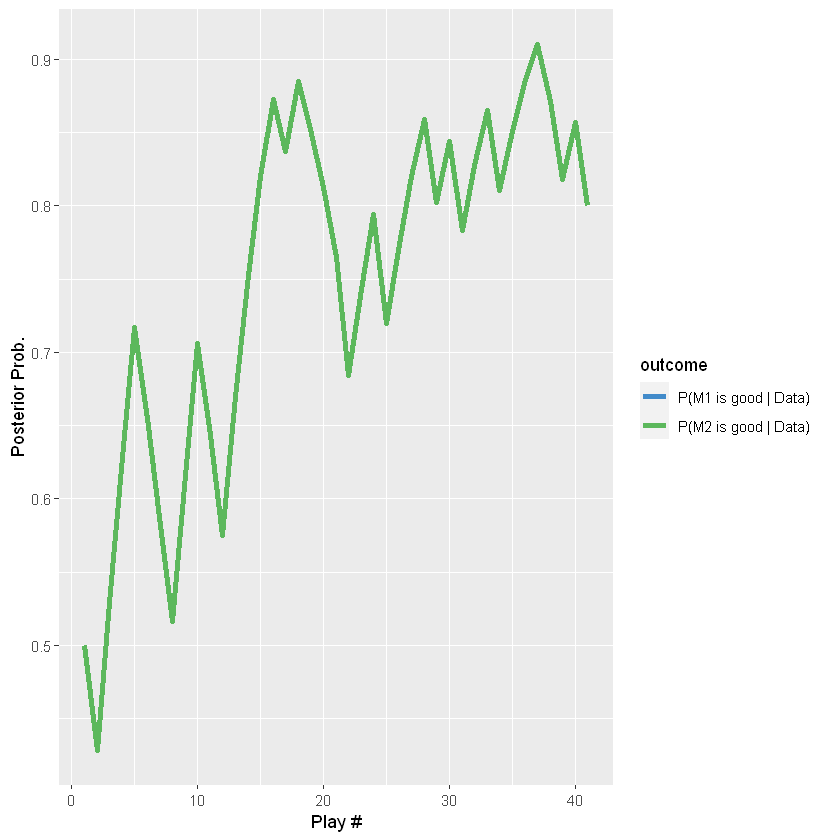

In [10]:
# Calculate posterior probabilities after each play and plot the result 
plot_bandit_posterior(data)


From the plot generated in the example above, we can see that the posterior probabilities for Machine 1 and Machine 2 mirror each other. Why will this happen?

* $P(M_1~|~\text{data})$ and $P(M_2~|~\text{data})$ are complementary
* Machine 1 and Machine 2 being "good" are mutually exclusive events
* **Both of the above**